# Introducción

La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

El objetivo de este proyecto es verificar las características de por qué los clientes se van y recomendar los planes según tipo de consumo. La exploración se hará con un sistema de recomendación.

**Pasos a seguir**
1. Importación de bibliotecas
2. Análisis de los datos 
3. Limpieza y procesamiento 
4. Modelos: ábol de decisión y random forest
5. Conclusiones

# Importación de bibliotecas

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np


# Lectura de Dataset
df = pd.read_csv('/datasets/users_behavior.csv')

# Inspección de datos
print(df.info())
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
      calls  minutes  messages   mb_used  is_ultra
3128   64.0   433.68      87.0  18832.67         0
3156   86.0   639.94      34.0  16810.40         0
428    77.0   483.58      68.0  13806.44         0
369    59.0   338.25      18.0  18220.57         0
1491   63.0   385.09      18.0  14518.03         0
1257   68.0   543.50       2.0  11372.29         0
1936  124.0   806.93      28.0  21972.66         1
136    85.0   464.24       9.0  18225.93         0
109    35.0   256.82       0.0   9545.00         1
1414   44.0   287.93       9.0  27093.07         0


**Observaciones**

Podemos ver que el dataset consta de 3,214 registros aparentemente no nulos. 5 columnas: Calls, minutes, messages y mb_used de tipo float y is_ultra de tipo entero. De acuerdo al diccionario, las primeras 4 columnas, son númericas que denotan el consumo del plan del usuario.

In [2]:
# Verificamos si no hay valores ausentes
print(df.isna().sum())

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


In [3]:
# Verificamos si hay valores duplicados
print(df.duplicated().sum())

0


**Observaciones**

Una vez visto que no hay que castear los tipos de datos de las columnas, verificamos si no hay valores ausentes y duplicados. Comprobamos que los datos están limpios. Por lo que procedemos a hacer la separación del dataset para entrenar y validar los modelos. 

# Árbol de Decisión

In [4]:
# Separamos las características y etiqueta/objetivo
X = df.drop("is_ultra", axis=1)
y = df["is_ultra"]

# Dividimos los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buscamos la mejor profundidad
best_accuracy = 0
best_depth = 0
for depth in range(1, 21):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print(f"Mejor profundidad: {best_depth} con exactitud: {best_accuracy:.2%}")


Mejor profundidad: 7 con exactitud: 81.03%


**Observaciones**

Una vez que se crearon los conjuntos de entrenamiento y prueba, buscamos la exactitud y la mejor profundidas para crear el árbol óptimo. Lo que nos arrojó el algoritmo fue que la mejor profundidad para el aprendizaje, fue 7 y la exactitud de la predcción fue 81%. Por lo que no está nada mal. 

Ahora prodecemos a crear el árbol óptimo y visualizar el ábol de decisión final.

7


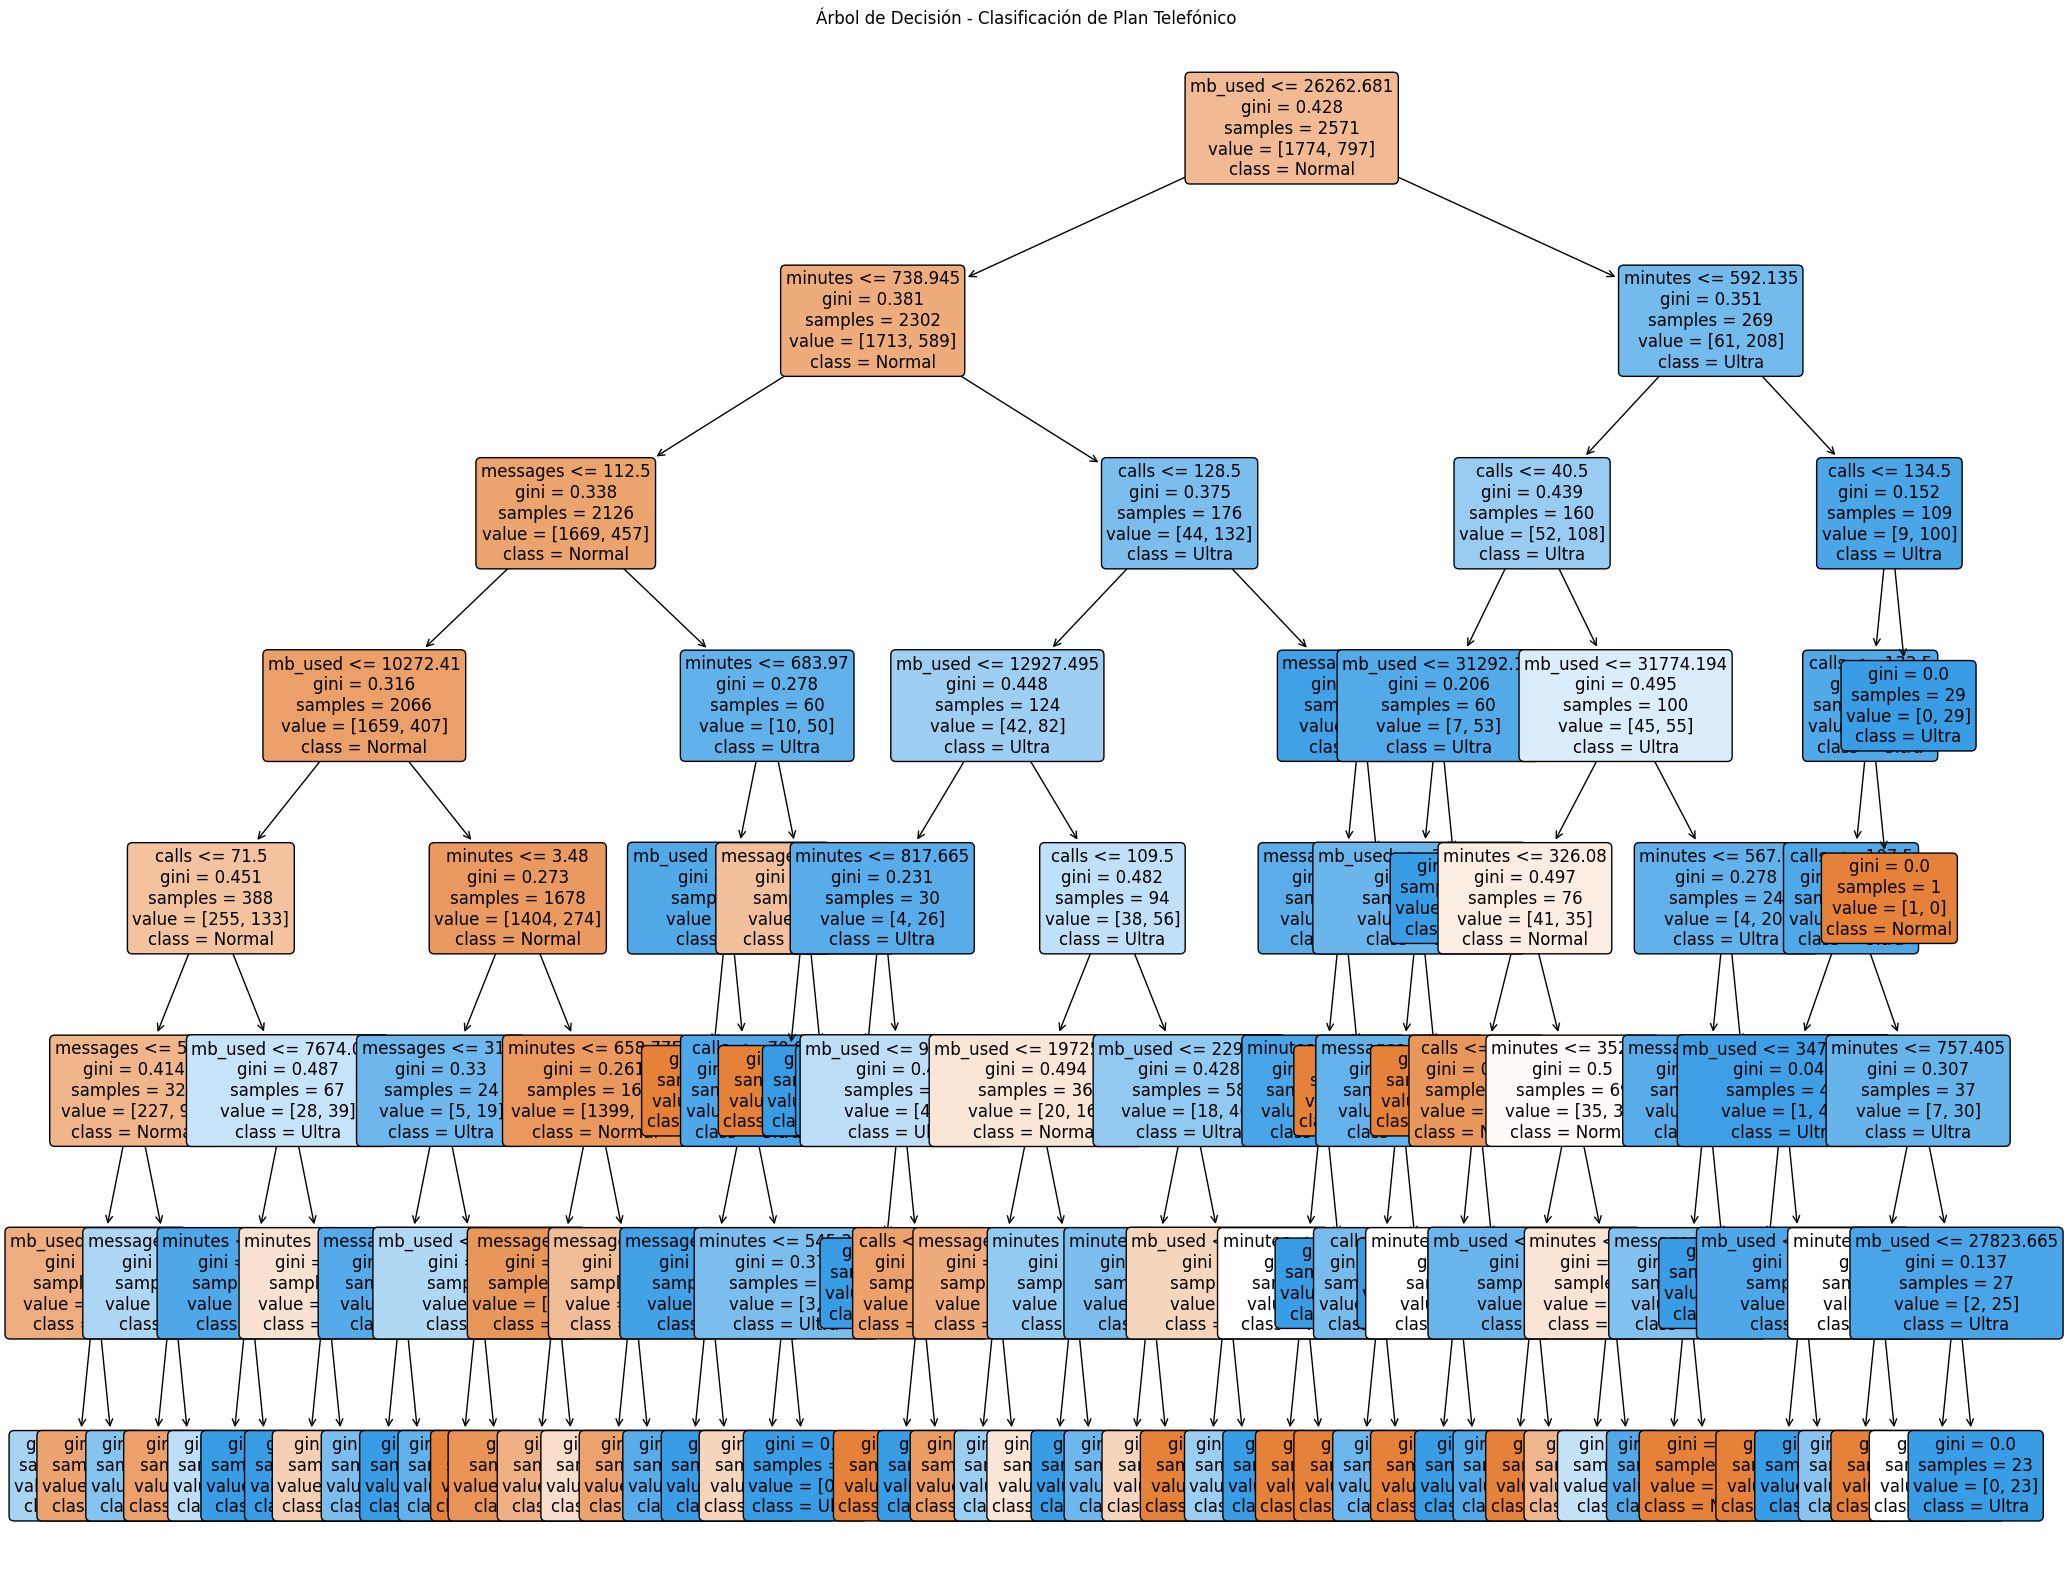

In [5]:
# Entrenamos el árbol óptimo
print(best_depth)
final_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_tree.fit(X_train, y_train)

plt.figure(figsize=(25, 20))
plot_tree(
    final_tree,
    feature_names=X.columns,
    class_names=["Normal", "Ultra"],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Árbol de Decisión - Clasificación de Plan Telefónico")
plt.show()


**Observaciones**

Los árboles de decisión dividen los datos en función de qué variables son mejores. En este caso, los que define al mejor plan. En este árbol, las divisiones clave que llevan a deducir que el plan Ultra es mejor son:

1. Mayor uso de megas (mb_used)
2. Mayor cantidad de minutos
3. Y puede paracer que también mayor cantidad de mensajes

Entonces podemos decir:

* Los usuarios del Plan Ultra tienden a consumir más datos, minutos o mensajes.

Si nos fijamos en la primera rama de la izquierda (naranja), podemos observar que menos sean los megas usados, mensajes y mínutos, tienden ser de *plan Normal*. Mientras que la derecha del árbol, predomina el *plan Ultra*. 

¿Qué implica esto?

* El Plan Ultra probablemente fue contratado por personas con hábitos de uso más altos, o bien

* El plan Ultra permite más consumo sin penalización, y por eso los usuarios lo usan más

En cualquier caso, sí podemos decir que el modelo encontró una relación fuerte entre mayor uso y Plan Ultra.

Veamos cómo se ven los promedios de los planes


In [6]:
promedios = df.groupby("is_ultra").mean(numeric_only=True)

promedios.index = ["Normal", "Ultra"]

print(promedios)

            calls     minutes   messages       mb_used
Normal  58.463437  405.942952  33.384029  16208.466949
Ultra   73.392893  511.224569  49.363452  19468.823228


**Observaciones**

Podemos ver que en efecto, el *Plan Ultra*, tiene más llamadas, minutos, mensajes y megas usados.

In [7]:
# Prueba de cordura
# Creamos un usuario inactivo y otro muy activo

users = pd.DataFrame({
    'calls': [0, 300],           
    'minutes': [0.0, 6000.0],
    'messages': [0, 600],
    'mb_used': [0.0, 100000.0]
})

# Predecir
predicciones_extremos = tree.predict(users)
print("Predicción para usuario casi inactivo:", predicciones_extremos[0]) 
print("Predicción para usuario extremadamente activo:", predicciones_extremos[1])

Predicción para usuario casi inactivo: 0
Predicción para usuario extremadamente activo: 1


**Observaciones**

Podemos ver en la prueba de cordura que la clasificación la hace bien. Por lo que podemos decir que nuestro calsificador, aprendió bien.

In [8]:
# Prueba con cambio de parámetro

# Cambio del tamaño del conjunto de prueba del 20% al 25%

# Separamos las características y etiqueta/objetivo
X = df.drop("is_ultra", axis=1)
y = df["is_ultra"]

# Dividimos los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Buscamos la mejor profundidad
best_accuracy = 0
best_depth = 0
for depth in range(1, 21):
    tree_proof = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_proof.fit(X_train, y_train)
    y_pred = tree_proof.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print(f"Mejor profundidad: {best_depth} con exactitud: {best_accuracy:.2%}")

Mejor profundidad: 4 con exactitud: 80.60%


In [9]:

users = pd.DataFrame({
    'calls': [0, 300],           
    'minutes': [0.0, 6000.0],
    'messages': [0, 600],
    'mb_used': [0.0, 100000.0]
})

# Predecir
predicciones_extremos = tree_proof.predict(users)
print("Predicción para usuario casi inactivo:", predicciones_extremos[0]) 
print("Predicción para usuario extremadamente activo:", predicciones_extremos[1])

Predicción para usuario casi inactivo: 1
Predicción para usuario extremadamente activo: 1


**Observaciones**

Ejecutamos el clasificador con un conjunto de prueba más grande y obtuvimos que la profundidad del árbol disminuyó. Pasó de ser de profundidad 7 a 4 y de una exactitud del 81.03% a 80.6%. No hay mucho cambio en la exactitud pero sí en la profundidad. Por lo que podemos decir que aprendió más rápido y mejor. Sin embargo, al hacer la prueba de cordura con los mismos parámetros, *un usuario súper activo y uno nada activo*, obtuvimos que los clasificó en el *Plan ultra*. 

Esto significa, que el modelo de sobreajustó o se entrenó mal. Posiblemente hay más etiquetas que son el plan ultra.

# Bosque aleatorio de regresión

Ahora, usaremos el árbol de decisión de regresión. Sin embargo, la variable objetivo (is_ultra), es categórica y no podemos hacer la regresión, ya que necesitamos que sea númerica. 

Usaremos *RandomForestRegressor* para predecir un valor continuo entre 0 y 1.

Luego interpretaremos el valor final como una probabilidad de que el usuario sea "Ultra".

Al solo haber dos planes, tomaremos una decisión binaria. Por lo que estableceremos un umbral de aceptación para el plan Ultra. Si el resultados es mayor a 0.5 entonces *Plan Ultra*, en otro caso *Plan Normal*.

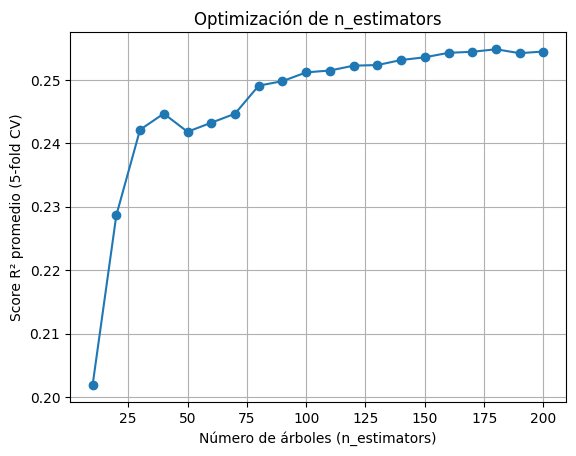

In [10]:
# Verificamos cuántos n_estimators el modelo es viable

# Seleccionamos 200 estimadores
estimators_range = range(10, 201, 10)
scores = []

for n in estimators_range:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    # Cross validation con 5 folds (métrica R²)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    scores.append(np.mean(cv_score))

# Graficar
plt.plot(estimators_range, scores, marker='o')
plt.xlabel("Número de árboles (n_estimators)")
plt.ylabel("Score R² promedio (5-fold CV)")
plt.title("Optimización de n_estimators")
plt.grid(True)
plt.show()

**Observaciones**

Vemos que a partir de 160 estimadores, no hay gran cambio en el aprendizaje. Por lo que seleccionaremos 160 n_estimators

In [11]:
# Entrenamos el modelo como regresor con 40 estimadores

regressor = RandomForestRegressor(n_estimators=160, random_state=42)
regressor.fit(X_train, y_train)

# Predecir valores continuos, tipo "probabilidad"
y_pred_reg = regressor.predict(X_test)

# Evaluamos con métricas de regresión. 
mse = mean_squared_error(y_test, y_pred_reg)
rmse = mse**0.5

print(f"MSE: {mse:.4f}")
print(f"RMSE Score: {rmse:.4f}")

# Convertir a clases usando umbral 0.5
y_pred_clase = (y_pred_reg > 0.5).astype(int)

# Comparar con accuracy de clasificación binaria
from sklearn.metrics import accuracy_score
acc_bin = accuracy_score(y_test, y_pred_clase)
print(f"Precisión binaria con umbral 0.5: {acc_bin:.2%}")

MSE: 0.1409
RMSE Score: 0.3754
Precisión binaria con umbral 0.5: 82.84%


In [12]:
# Prueba de Cordura

extremos = pd.DataFrame({
    'calls': [0, 150],
    'minutes': [0.0, 3000.0],
    'messages': [0, 200],
    'mb_used': [0.0, 100000.0]
})

# Predecir valores continuos (probabilidades)
predicciones = regressor.predict(extremos)

# Mostrar resultados
for i, (entrada, pred) in enumerate(zip(extremos.to_dict(orient='records'), predicciones)):
    print(f"Ejemplo {i+1}: Entrada: {entrada}")
    print(f"Predicción continua (tipo probabilidad): {pred:.4f}\n")

Ejemplo 1: Entrada: {'calls': 0, 'minutes': 0.0, 'messages': 0, 'mb_used': 0.0}
Predicción continua (tipo probabilidad): 0.8187

Ejemplo 2: Entrada: {'calls': 150, 'minutes': 3000.0, 'messages': 200, 'mb_used': 100000.0}
Predicción continua (tipo probabilidad): 1.0000



In [13]:
print(df[df['is_ultra'] == 0]['calls'].count())
print(df[df['is_ultra'] == 1]['calls'].count())

2229
985


**Observaciones**

Podemos observar que el modelo predice que incluso un usuario completamente inactivo tiene una probabilidad del 81% de ser del plan Ultra. Esto no tiene sentido lógico, ya que ese usuario claramente no necesita un plan más caro.

El usuario muy activo sí tiene un 100%, lo cual sí es coherente.

Este modelo está sobreestimando fuertemente la probabilidad de clase 1, lo que esto sugiere es:

* Un posible desbalance en las clases del entrenamiento. Es decir, que haya más registros de un plan que del otro. En este caso, sería el plan Normal.
* O una tendencia del modelo a sobreajustarse a ciertos patrones comunes.

# Conclusiones generales

En este proyecto utilizamos 2 algoritmos para determinar qué plan tarifario es mejor para recomendar a los usuarios:

1. Árbol de decisión 
2. Bosque aleatorio de regresión

Para realizar dicha recomendación, primero importamos las bibliotecas y el dataset que constana de 3,214 registros aparentemente no nulos. 5 columnas: Calls, minutes, messages y mb_used de tipo float y is_ultra de tipo entero. De acuerdo al diccionario, las primeras 4 columnas, son númericas que denotan el consumo del plan del usuario. No tuvimos la necesidad de hacer limpieza de los datos. Por lo que procedimos a hacer la división de los conjuntos de entrenamiento y prueba. 


**Árbol de decisión**

Para este algoritmo, primero determinamos cuál era la profundidad del árbol más adecuada para el aprendizaje y la exactitud. Lo que el algoritmo arrojó fue una profundidad de 7 y la exactitud de la predcción fue 81%. Por lo que no está nada mal.

El árbol óptimo lo sacamos y lo gráficamos. Lo que pudimos notar que el árbol es muy grande y que podemos podar. Pues al momento de hacer pruebas con el conjunto de entrenamiento, si le pasabamos un conjunto grande, al momento de hacer las pruebas de cordura, nos daba la clase 1 (Plan ultra). Dichas pruebas eran 2 usuarios, uno no activo y el otro, extremadamente activo. Por lo que esperamos que en e usuario inactivo, fuera de clase 0 (Plan Normal). 

Por lo que los datos están desbalanceados, al parecer hay más plan Normal que ultra por lo que se puede llegar a sesgar el resultados por el conjuntos de entrenamiento. 

**Bosque aleatorio de regresión**

Para este algoritmo, la variable objetivo (is_ultra), era categórica y no podíamos hacer la regresión, ya que necesitamos que fuera númerica.

Usamos *RandomForestRegressor* para predecir un valor continuo entre 0 y 1. La interpretación que manejamos fue que el valor final fuera una probabilidad de que el usuarios fuera *Ultra*. Al solo haber dos planes, tomamos una decisión binaria. Por lo que establecimos un umbral de aceptación para el plan Ultra. Si el resultado fue mayor a 0.5 entonces Plan Ultra, en otro caso Plan Normal.

Para ejecutar el algoritmo *randomforestregressor*, primero calculamos cuántos *n_estimators* eran adecuados para el procedimiento. Pudimos ver en la gráfica que la curva dejaba de incrementar a partir de 160 estimadores. Por lo que el algoritmo lo corrimos para 160 estimadores. 

El resultado que obtuvimos fue que teníamos una precisión del 82% con un error cuadrático 0.14 y un rmse de 0.37, realmente bajo y aceptable. Sin embargo, al hacer las pruebas de cordura, notamos que había sobreajuste. Algo realmente extraño en los randomforest, surgió la duda de que posiblemente hubiese un sesgo y sí, al momento de verificar cuántos registros había del plan normal y cuántos de plan ultra, notamos que había más del doble del plan normal que ultra. Esto afecta al aprendizaje de los algoritmos. 

Sin embargo, en el clasificador del árbol de decisión, notamos que el mejor plan para los usuarios era el plan ultra por:

1. Mayor uso de megas (mb_used)
2. Mayor cantidad de minutos
3. Y puede paracer que también mayor cantidad de mensajes

Entonces podemos decir que:

Los usuarios del Plan Ultra tienden a consumir más datos, minutos o mensajes.
Si nos fijamos en la primera rama de la izquierda (naranja), podemos observar que menos sean los megas usados, mensajes y mínutos, tienden ser de plan Normal. Mientras que la derecha del árbol, predomina el plan Ultra.

¿Qué implica esto?

El Plan Ultra probablemente fue contratado por personas con hábitos de uso más altos, o bien

El plan Ultra permite más consumo sin penalización, y por eso los usuarios lo usan más

En cualquier caso, sí podemos decir que el modelo encontró una relación fuerte entre mayor uso y Plan Ultra.